In [42]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

from sklearn.neighbors import KNeighborsRegressor

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics import mean_squared_error

In [4]:
item_categories = pd.read_csv('item_categories.csv')
items = pd.read_csv('items.csv.zip')
sales_train = pd.read_csv('sales_train.csv.zip',  parse_dates=['date'], dtype={'date': 'str', 'date_block_num': 'int32', 'shop_id': 'int32','item_id': 'int32', 'item_price': 'float32', 'item_cnt_day': 'int32'})
sample_submissions = pd.read_csv('sample_submission.csv.zip')
shops = pd.read_csv('shops.csv')
test = pd.read_csv('test.csv.zip')

In [5]:
item_categories.head(3)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2


In [6]:
items.head(3)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40


In [7]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,22154,999.000000,1
1,2013-03-01,0,25,2552,899.000000,1
2,2013-05-01,0,25,2552,899.000000,-1
3,2013-06-01,0,25,2554,1709.050049,1
4,2013-01-15,0,25,2555,1099.000000,1


In [8]:
sample_submissions.head(3)

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5


In [9]:
shops.head(3)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2


In [10]:
test.head(3)

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233


## Here we merge all tables related with the train data into one table

In [11]:
# merge data into one table
train = sales_train.join(items, on = 'item_id', rsuffix='_')\
                    .join(item_categories, on = 'item_category_id', rsuffix = '_')\
                    .join(shops, on = 'shop_id', rsuffix = '_')\
                    .drop(['item_id_', 'shop_id_', 'item_category_id_', 'item_name'], axis=1)

train['item_cnt_day'] = np.abs(train['item_cnt_day'])
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,item_category_name,shop_name
0,2013-02-01,0,59,22154,999.000000,1,37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
1,2013-03-01,0,25,2552,899.000000,1,58,Музыка - Винил,"Москва ТРК ""Атриум"""
2,2013-05-01,0,25,2552,899.000000,1,58,Музыка - Винил,"Москва ТРК ""Атриум"""
3,2013-06-01,0,25,2554,1709.050049,1,58,Музыка - Винил,"Москва ТРК ""Атриум"""
4,2013-01-15,0,25,2555,1099.000000,1,56,Музыка - CD фирменного производства,"Москва ТРК ""Атриум"""


## Split dates for more detailed exploration

In [12]:
train['date'] = pd.to_datetime(train['date'], format='%m.%Y')
train['day'] = train['date'].dt.day
train['month'] = train['date'].dt.month
train['year'] = train['date'].dt.year

train.head(4)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,item_category_name,shop_name,day,month,year
0,2013-02-01,0,59,22154,999.000000,1,37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир""",1,2,2013
1,2013-03-01,0,25,2552,899.000000,1,58,Музыка - Винил,"Москва ТРК ""Атриум""",1,3,2013
2,2013-05-01,0,25,2552,899.000000,1,58,Музыка - Винил,"Москва ТРК ""Атриум""",1,5,2013
3,2013-06-01,0,25,2554,1709.050049,1,58,Музыка - Винил,"Москва ТРК ""Атриум""",1,6,2013


## Check our data for missed values

In [13]:
train.isnull().sum()

date                  0
date_block_num        0
shop_id               0
item_id               0
item_price            0
item_cnt_day          0
item_category_id      0
item_category_name    0
shop_name             0
day                   0
month                 0
year                  0
dtype: int64

## Group data by date, shop, item and category 

In [106]:
# group data by month
train_grouped_by_month = train[["month", "date_block_num", "shop_id", "item_id", "item_price", "item_cnt_day", "item_category_id", "year"]].groupby(['date_block_num',"shop_id", "item_id", "item_category_id"]).agg({"item_price":"mean","item_cnt_day":"sum","month":"min", "year":"min"}).reset_index()
train_grouped_by_month.rename(columns={"item_cnt_day": "item_cnt_month"}, inplace=True)

train_grouped_by_month.head(8)

,date_block_num,shop_id,item_id,item_category_id,item_price,item_cnt_month,month,year
0,0,0,32,40,221.0,6,1,2013
1,0,0,33,37,347.0,3,1,2013
2,0,0,35,40,247.0,1,1,2013
3,0,0,43,40,221.0,1,1,2013
4,0,0,51,57,128.5,2,1,2013
5,0,0,61,43,195.0,1,10,2013
6,0,0,75,40,76.0,1,1,2013
7,0,0,88,40,76.0,1,1,2013


## Here we can see, that almost all grouped sales are clipped into [0, 250]

<AxesSubplot:>

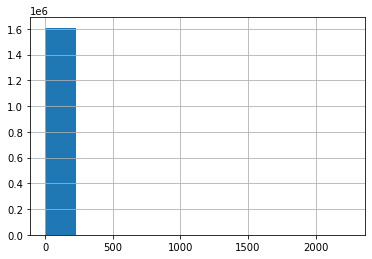

In [112]:
train_grouped_by_month['item_cnt_month'].hist()

## After 20 values are much less than for sales count from [0,20]

<AxesSubplot:>

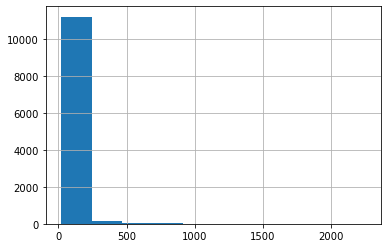

In [117]:
train_grouped_by_month.query('item_cnt_month > 20')['item_cnt_month'].hist()

<AxesSubplot:>

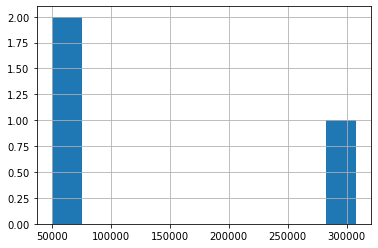

In [128]:
train_grouped_by_month.query('item_price > 45000')['item_price'].hist()

In [130]:
# remove outliers. We delete values less then 21, because final answer values have to belongs to range [0,20]
train_grouped_by_month = train_grouped_by_month.query('item_cnt_month >= 0 and item_cnt_month <= 20')

## We cant get anything helpful from this graphic

<AxesSubplot:>

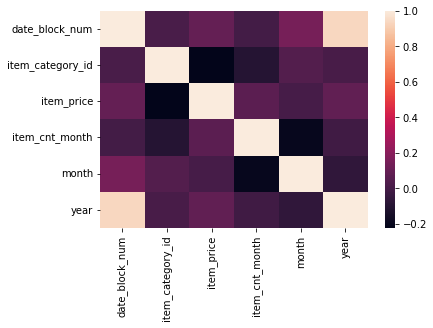

In [131]:
# calculate correlation matrix
sns.heatmap(train_grouped_by_month.drop(['shop_id', 'item_id'], axis=1).corr())

## From this graphic we can obtain that sales have huge values on december

<AxesSubplot:xlabel='date_block_num'>

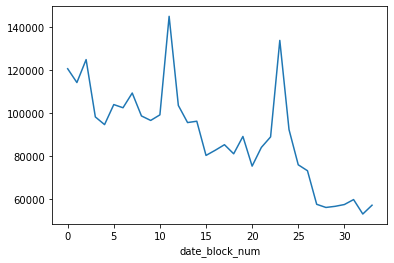

In [132]:
sales_by_date = train_grouped_by_month.groupby(['date_block_num'])['item_cnt_month'].sum()
sales_by_date.plot()

## We see that category №40 has more deifferent items, so we can split it into bins in future

C:\Users\Yauheni_Minau\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


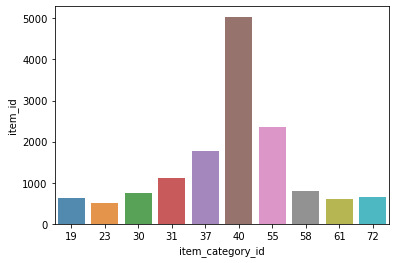

In [133]:
# number of items per category 
x=items.groupby(['item_category_id']).count()
x=x.sort_values(by='item_id',ascending=False)
x=x.iloc[0:10].reset_index()
ax= sns.barplot(x.item_category_id, x.item_id, alpha=0.85)
plt.show()

## Obviously sales are decreaing

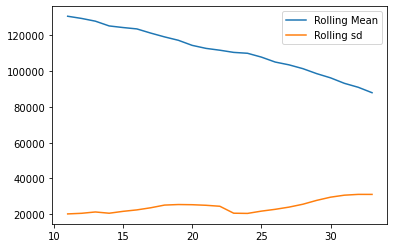

In [85]:
# rolling mean and standart deviation
plt.plot(sales_by_date.rolling(window=12,center=False).mean(),label='Rolling Mean');
plt.plot(sales_by_date.rolling(window=12,center=False).std(),label='Rolling sd');
plt.legend();

## We see that first month has the most biggest sales count

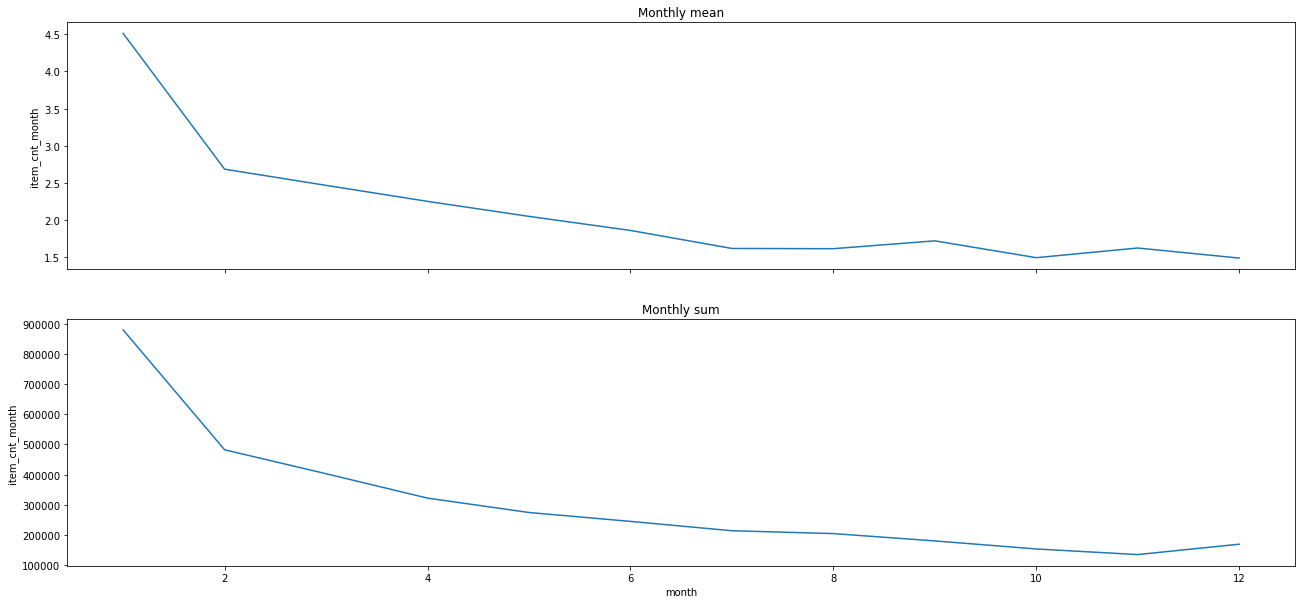

In [86]:
# check for sales statisticks depending on month
month_mean = train_grouped_by_month.groupby(['month'], as_index=False)['item_cnt_month'].mean()
month_sum = train_grouped_by_month.groupby(['month'], as_index=False)['item_cnt_month'].sum()

f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.lineplot(x="month", y="item_cnt_month", data=month_mean, ax=axes[0]).set_title("Monthly mean")
sns.lineplot(x="month", y="item_cnt_month", data=month_sum, ax=axes[1]).set_title("Monthly sum")
plt.show()

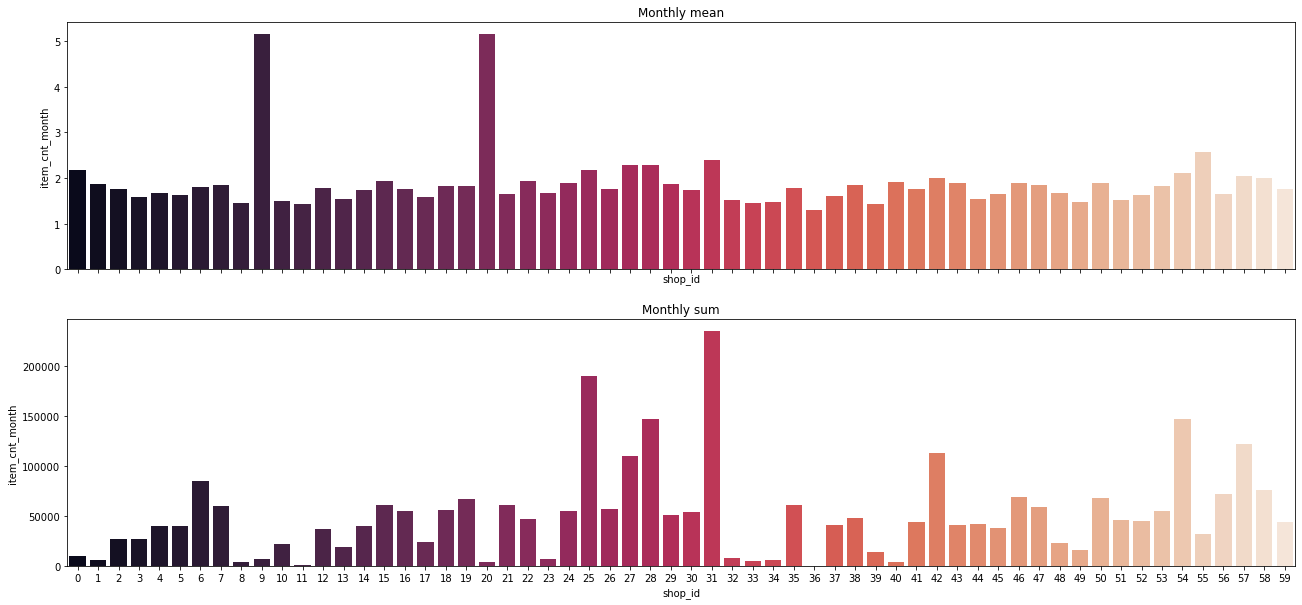

In [134]:
# check for sales statisticks depending on shop
shop_mean = train_grouped_by_month.groupby(['shop_id'], as_index=False)['item_cnt_month'].mean()
shop_sum = train_grouped_by_month.groupby(['shop_id'], as_index=False)['item_cnt_month'].sum()

f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="shop_id", y="item_cnt_month", data=shop_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="shop_id", y="item_cnt_month", data=shop_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
plt.show()

## We will use features 'shop_id', 'item_id', 'item_price', 'month', 'year', 'item_cnt_mean', 'shop_item_mean'

In [77]:
gp_shop_mean = train_grouped_by_month.groupby(['shop_id']).agg({'item_cnt_month': ['mean']})
gp_shop_mean.columns = ['shop_mean']
gp_shop_mean.reset_index(inplace=True)

gp_item_mean = train_grouped_by_month.groupby(['item_id']).agg({'item_cnt_month': ['mean']})
gp_item_mean.columns = ['item_mean']
gp_item_mean.reset_index(inplace=True)

gp_shop_item_mean = train_grouped_by_month.groupby(['shop_id', 'item_id']).agg({'item_cnt_month': ['mean']})
gp_shop_item_mean.columns = ['shop_item_mean']
gp_shop_item_mean.reset_index(inplace=True)

gp_year_mean = train_grouped_by_month.groupby(['year']).agg({'item_cnt_month': ['mean']})
gp_year_mean.columns = ['year_mean']
gp_year_mean.reset_index(inplace=True)

gp_month_mean = train_grouped_by_month.groupby(['month']).agg({'item_cnt_month': ['mean']})
gp_month_mean.columns = ['month_mean']
gp_month_mean.reset_index(inplace=True)

train = pd.merge(train, gp_shop_mean, on=['shop_id'], how='left')
train = pd.merge(train, gp_item_mean, on=['item_id'], how='left')
train = pd.merge(train, gp_shop_item_mean, on=['shop_id', 'item_id'], how='left')
train = pd.merge(train, gp_year_mean, on=['year'], how='left')
train = pd.merge(train, gp_month_mean, on=['month'], how='left')

test = pd.merge(test, gp_shop_mean, on=['shop_id'], how='left')
test = pd.merge(test, gp_item_mean, on=['item_id'], how='left')
test = pd.merge(test, gp_shop_item_mean, on=['shop_id', 'item_id'], how='left')
test = pd.merge(test, gp_year_mean, on=['year'], how='left')
test = pd.merge(test, gp_month_mean, on=['month'], how='left')

X_train = train.drop(['item_cnt_day', 'date_block_num'], axis=1)
Y_train = train['item_cnt_day'].astype(int)

test.head(3)

,ID,shop_id,item_id,year,month,item_price,item_cnt_mean,shop_item_mean_x,shop_mean,item_mean,shop_item_mean_y,year_mean,month_mean
0,0,5,5037,2015,9,0,0,0,1.638607,2.863946,1.444444,1.813718,1.476566
1,1,5,5320,2015,9,0,0,0,1.638607,NaN,NaN,1.813718,1.476566
2,2,5,5233,2015,9,0,0,0,1.638607,2.668421,2.000000,1.813718,1.476566


In [80]:
X_train.rename(columns={"shop_mean_x": "shop_mean", "shop_item_mean_x": "shop_item_mean", \
                        "year_mean_x": "year_mean", "month_mean_x": "month_mean", "item_mean_y": "item_mean"}, inplace=True)

test.rename(columns={"shop_mean_y": "shop_mean", "item_mean_y": "item_mean", "shop_item_mean_y": "shop_item_mean", \
                       "year_mean_y": "year_mean", "month_mean_y": "month_mean"}, inplace=True)

knn_features = ['shop_mean', 'shop_item_mean', 'year_mean', 'month_mean', 'item_mean']

X_train_sampled = X_train[:40000]
Y_train_sampled = Y_train[:40000]

knn_train = X_train_sampled[knn_features]
knn_test = test[knn_features]

C:\Users\Yauheni_Minau\Anaconda3\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [79]:
knn_scaler = MinMaxScaler()
knn_scaler.fit(knn_train)
knn_train = knn_scaler.transform(knn_train)
#knn_test = knn_scaler.transform(knn_test)

In [55]:
knn_model = KNeighborsRegressor(n_neighbors=9, leaf_size=13, n_jobs=-1)
knn_model.fit(knn_train, Y_train_sampled)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [56]:
knn_train_pred = knn_model.predict(knn_train)
knn_test_pred = knn_model.predict(knn_test)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [57]:
np.sqrt(mean_squared_error(Y_train_sampled, knn_train_pred))

In [ ]:
knn_test_pred